# Logistic and linear regression with deterministic and stochastic first order methods

    TP 3 : Optimisation - DataScience Master
    Authors : Stéphane Gaiffas, Alexandre Gramfort
   
The aim of this TP is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 
The following methods are compared in this notebook.

**Batch (deterministic) methods**
- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a section called **2016/11/21 Practical session **. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "leo"
ln1 = "treguer"
fn2 = "mehdi"
ln2 = "miah"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp3_treguer_leo_and_miah_mehdi.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2
$$
where
- $\ell(z, y) = \frac 12 (y - z)^2$ (least-squares regression)
- $\ell(z, y) = \log(1 + \exp(-yz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(\theta)
$$
where
$$
f_i(\theta) = \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(\theta) = (x_i^\top \theta - y_i) x_i + \lambda \theta
$$
and
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i x_i^\top \theta)} x_i + \lambda \theta.
$$

Denote by $L$ the Lipschitz constant of $f$ and by $L_i$ the Lipschitz constant of $f_i$. 
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{n} + \lambda \quad \text{ and } L_i = \| x_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| x_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / \max_{i=1,\ldots,n} L_i$

We now introduce a class that will be used for the solvers.

In [4]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        return (self.A).T.dot((self.A).dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm((self.A).dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.max(svd(self.A, full_matrices=False)[1]) ** 2 / self.n + self.lbda
        return L

In [5]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot((self.A).T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.sum(np.max(self.A ** 2, axis=1)) / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [6]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x_truth) + noise
    return A, b

In [7]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    A, b = simu_linreg(x, n, std=1., corr=0.5)
    return A, np.sign(b)

In [8]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

A, b = simu_linreg(x_truth, n, std=1., corr=0.7)

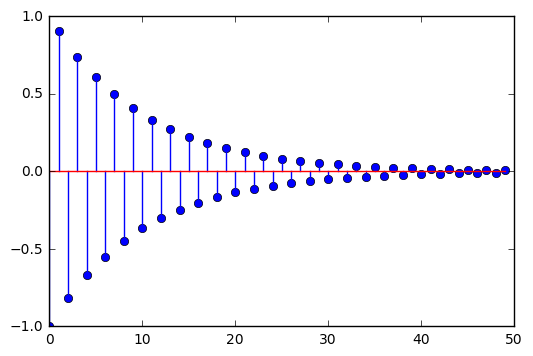

In [9]:
plt.stem(x_truth);

### Numerically check loss and gradient

In [10]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
model = LinReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.3699651203717603e-06

In [11]:
lbda = 1. / n ** (0.5)
model = LogReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

2.0495512816196166e-07

### Choice of the model

In [12]:
model = LinReg(A, b, lbda)
#model = LogReg(A, b, lbda)

### Compute the theoretical step-size for FISTA

In [13]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 0.177733794118


### Get a very precise minimum to compute distances to minimum

In [14]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
print(f_min)

0.5278273732189163


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BGFS)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [15]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

In [16]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

* (1) QUESTION*:
- Fill in the iteration of the Ista solver in the cell below

In [17]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x = x - step * grad(x)
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)

    return x

In [18]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_truth, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err   
       0 | 4.84e-01 | 2.11e+00
      10 | 2.09e-01 | 1.46e+00
      20 | 1.02e-01 | 1.03e+00
      30 | 5.06e-02 | 7.29e-01
      40 | 2.53e-02 | 5.17e-01


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

* (2) QUESTION*:
- Fill in the iteration of the Fista solver in the cell below

In [19]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        ### TODO
        x_old = x.copy()
        x = y - step * grad(y)
        t_old = t
        t = (1+np.sqrt(1+4*t**2))/2
        y = x + (t_old-1)/t*(x-x_old)
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [20]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_truth, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err   
       0 | 4.84e-01 | 2.11e+00
      10 | 7.44e-02 | 8.83e-01
      20 | 8.65e-04 | 8.87e-02
      30 | 1.52e-03 | 1.27e-01
      40 | 2.97e-04 | 5.54e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [21]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_truth, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err   
       0 | 4.16e-01 | 1.96e+00
      10 | 2.37e-04 | 3.51e-02
      20 | 1.80e-07 | 8.94e-04
Optimization terminated successfully.
         Current function value: 0.527827
         Iterations: 30
         Function evaluations: 56
         Gradient evaluations: 56


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [22]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_truth, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err   
       0 | 4.16e-01 | 1.96e+00
      10 | 4.79e-04 | 5.96e-02
      20 | 1.54e-07 | 9.60e-04


### A first numerical comparison of deterministic solvers

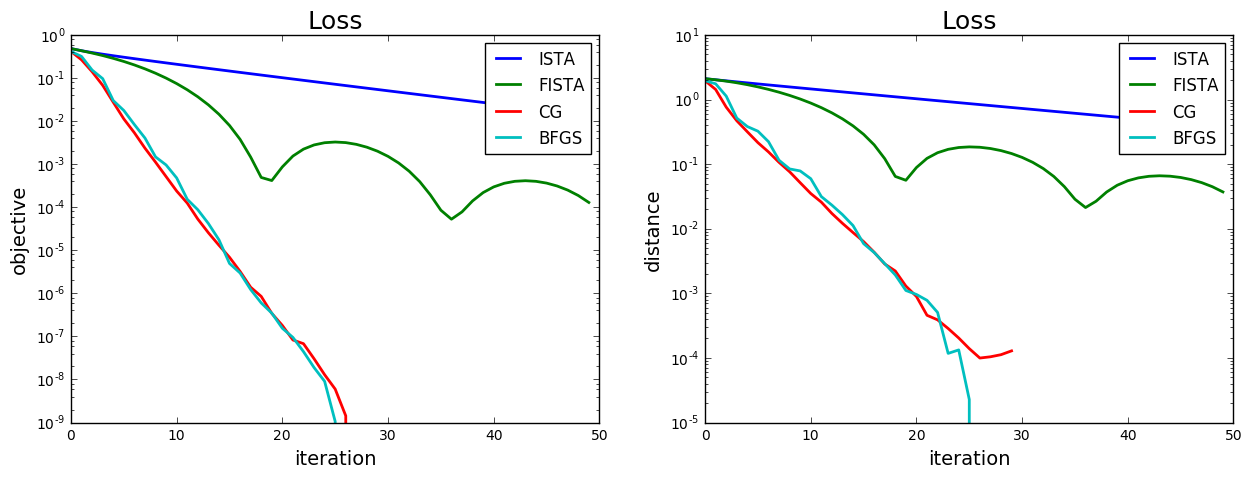

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

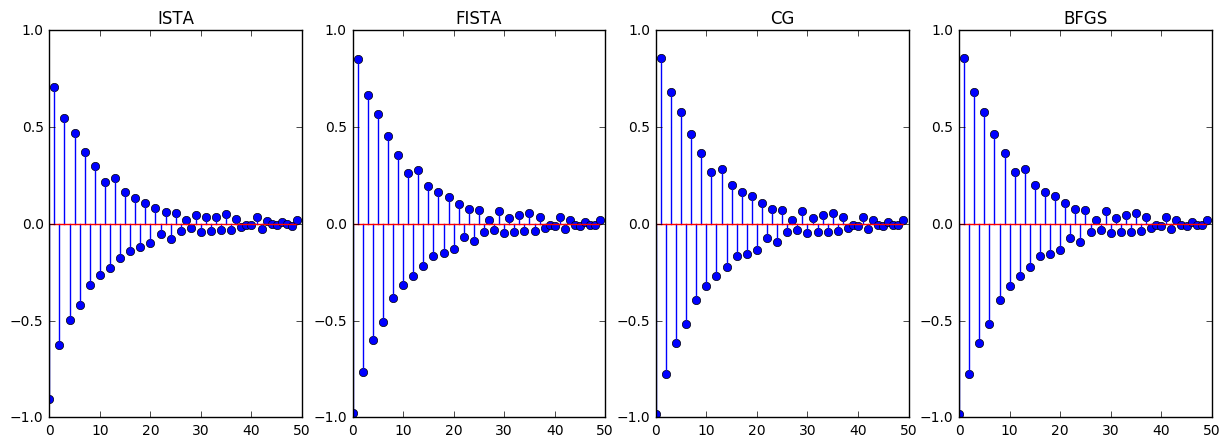

In [24]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

* (3) QUESTIONS*:

- Give some first conclusions about the batch solver studied here

Order of algorithms
BFGS very fast
linear : GD
- What do you observe about Fista, is it suprising ?
Fista : bound ; not surprising because it is not a decreasing algorithm

<a id='stoc'></a> 
## 4. Stochastic methods

In [25]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

* (4) QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [26]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx] # We took a random number
        
        ### TODO
        x -= step * grad_i(i,x)/(np.sqrt(idx+1))

        ### END TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [27]:
step0 = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_truth, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err   
       0 | 1.51e+00 | 2.46e+00
      10 | 8.36e-03 | 1.14e-01
      20 | 4.78e-03 | 9.07e-02
      30 | 4.56e-03 | 8.71e-02
      40 | 3.61e-03 | 9.34e-02


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

* (5) QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

Need to be optimized (mise à jour de la moyenne)

In [28]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d)) #n rows, d columns ! 
    y = gradient_memory.mean(axis = 0) #np.zeros(d) #takes the value of G_t

    for idx in range(n_iter):
        i = iis[idx] #we took a random number
        
        ### TODO
        #gradient_memory[i, :] = grad_i(i, x)
        #y = gradient_memory.mean(axis = 1)
        #x = x - step * y
        
        y = (n * y - gradient_memory[i, :] + grad_i(i,x)) / n
        gradient_memory[i, : ] = grad_i(i,x)
        x = x - step * y
        
        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [29]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_truth, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err   
       0 | 5.82e-01 | 2.20e+00
      10 | 1.13e-03 | 4.61e-02
      20 | 3.05e-06 | 2.44e-03
      30 | 2.21e-08 | 2.66e-04
      40 | -2.86e-09 | 1.52e-04


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

* (6) QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

Need to be optimized (lazy updates)

In [30]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    for idx in range(n_iter):
        if(idx % n == 0):    
            x_old = x.copy()
            mu = grad(x_old)
        i = iis[idx]
        x = x - step * (grad_i(i, x) - grad_i(i, x_old) + mu)                      
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [31]:
#step = 1. / (20. * model.lipschitz_constant()) non car on garde le meme step
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)
    
x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_truth, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err   
       0 | 5.78e-01 | 2.19e+00
      10 | 2.14e-08 | 2.53e-04
      20 | -3.01e-09 | 1.52e-04
      30 | -3.01e-09 | 1.52e-04
      40 | -3.01e-09 | 1.52e-04


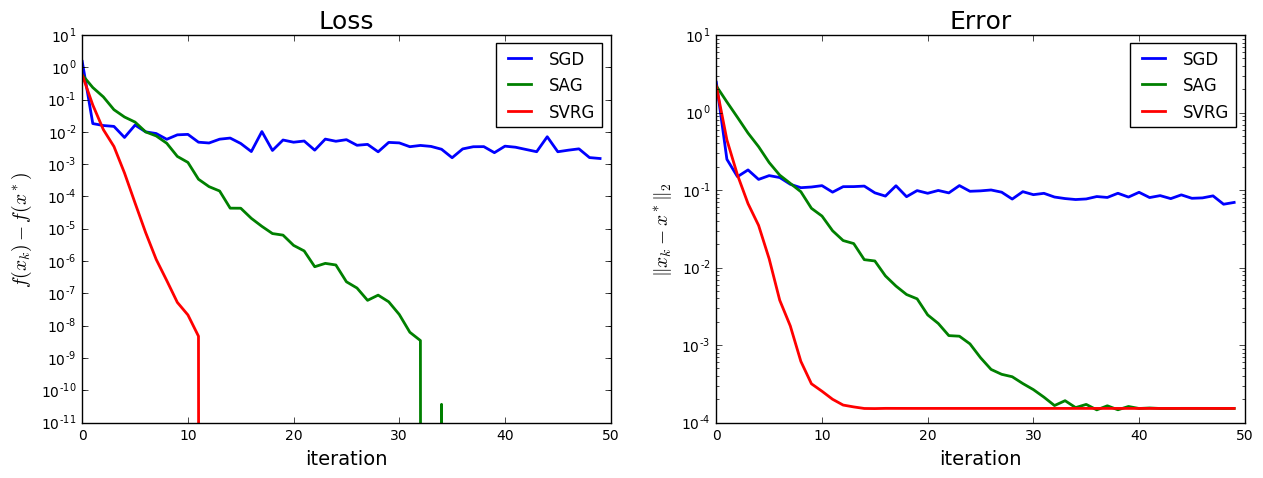

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

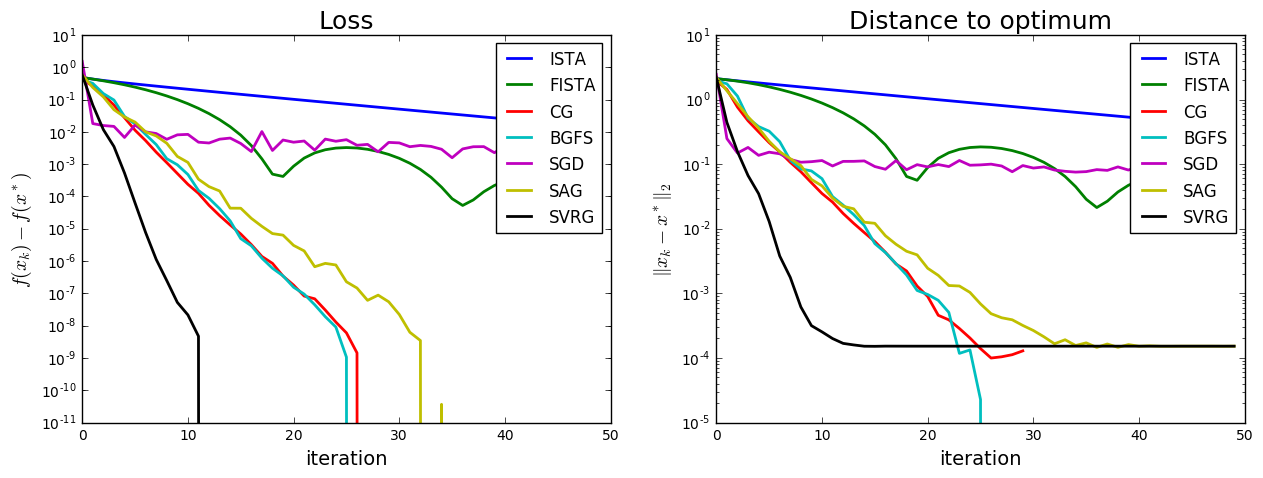

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

* (7) QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

## Linear case

### Influence of Ridge regularization

In [34]:
lbda_vect = [1. /n , 1. /n**0.5]

Optimization terminated successfully.
         Current function value: 0.495479
         Iterations: 36
         Function evaluations: 64
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 0.534619
         Iterations: 33
         Function evaluations: 57
         Gradient evaluations: 57


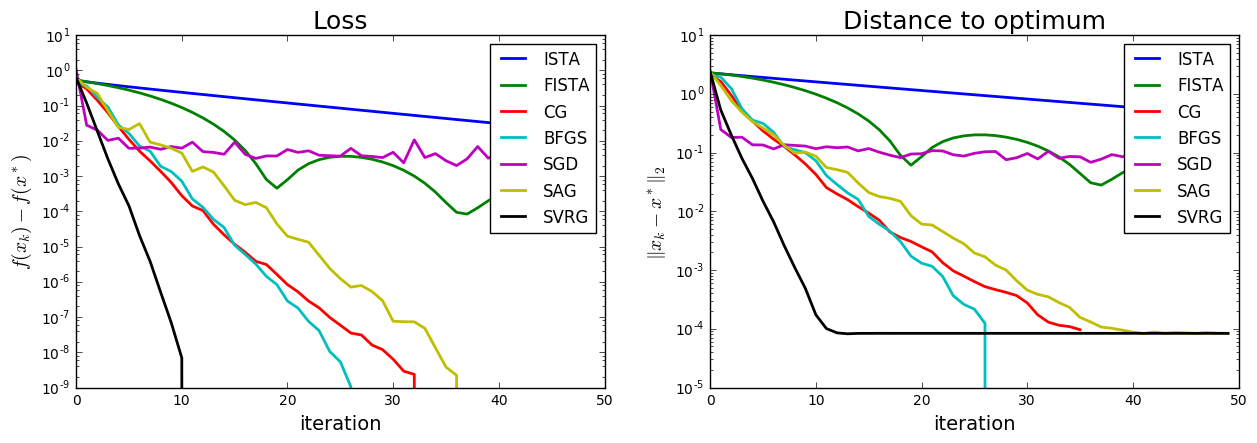

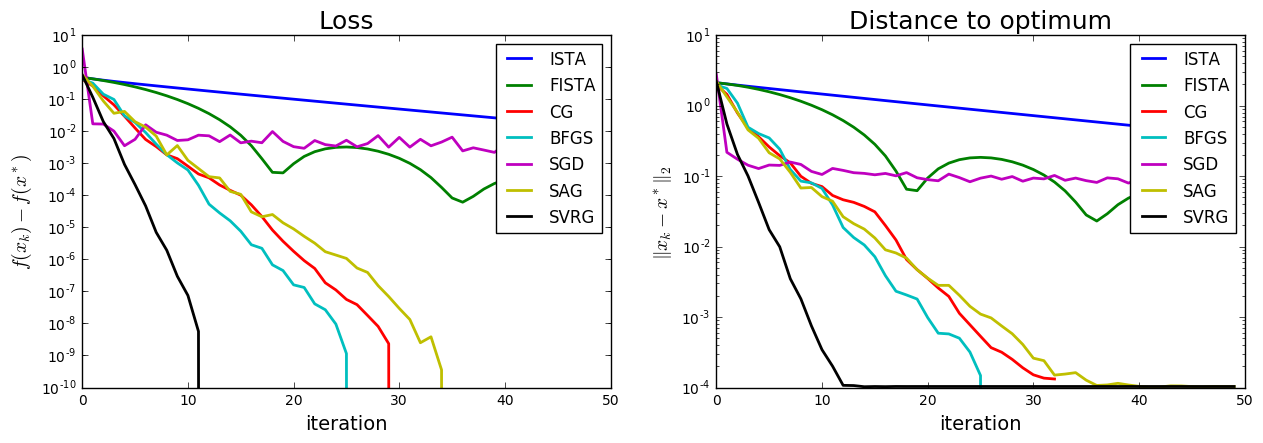

In [42]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

for lbda_ind in range(len(lbda_vect)):
    # Simulation
    A, b = simu_linreg(x_truth, n, std=1., corr=0.7)
    lbda = lbda_vect[lbda_ind]
    model = LinReg(A, b, lbda)

    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

    n_iter = 50

    plt.figure(figsize=(15,10))

    plt.subplot(2, 2, lbda_ind*2+1)

    #Inspectors

    #Ista
    step = 1. / model.lipschitz_constant()
    ista_inspector = inspector(model.loss, x_truth, verbose=False)
    x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

    #Fista
    step = 1. / model.lipschitz_constant()
    fista_inspector = inspector(model.loss, x_truth, verbose=False)
    x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

    #Coordinate gradient
    cg_inspector = inspector(model.loss, x_truth, verbose=False)
    x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

    #BFGS
    bfgs_inspector = inspector(model.loss, x_truth, verbose=False)
    x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

    iis = np.random.randint(0, n, n * n_iter) 

    #SGD
    step0 = 1. / model.lipschitz_constant()
    sgd_inspector = inspector(model.loss, x_truth, verbose=False)
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

    #SAG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
    else:
        step = 1.0 / (max_squared_sum + model.lbda / model.n)
    sag_inspector = inspector(model.loss, x_truth, verbose=False)
    x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

    #SVRG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
    else:
        step = 1.0 / (max_squared_sum + model.lbda / model.n)
    svrg_inspector = inspector(model.loss, x_truth, verbose=False) 
    x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

    #Plots of each model
    inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector, 
                 sgd_inspector, sag_inspector, svrg_inspector
                 ]

    solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    for insp in inspectors:
        plt.plot(insp.obj, lw=2)
        plt.title("Loss", fontsize=18)
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
        plt.yscale("log")

    plt.legend(solvers)

    plt.subplot(2, 2, lbda_ind*2+2)

    for insp in inspectors:
        plt.plot(insp.err, lw=2)
        plt.title("Distance to optimum", fontsize=18)
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
        plt.yscale("log")

    plt.legend(solvers);

### Influence of correlation

In [47]:
corr_vect = [0, 0.3, 0.7, 0.95, 0.999]

Optimization terminated successfully.
         Current function value: 0.521893
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.525053
         Iterations: 14
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.533244
         Iterations: 31
         Function evaluations: 58
         Gradient evaluations: 58
         Current function value: 0.527207
         Iterations: 50
         Function evaluations: 89
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: 0.502979
         Iterations: 43
         Function evaluations: 114
         Gradient evaluations: 114


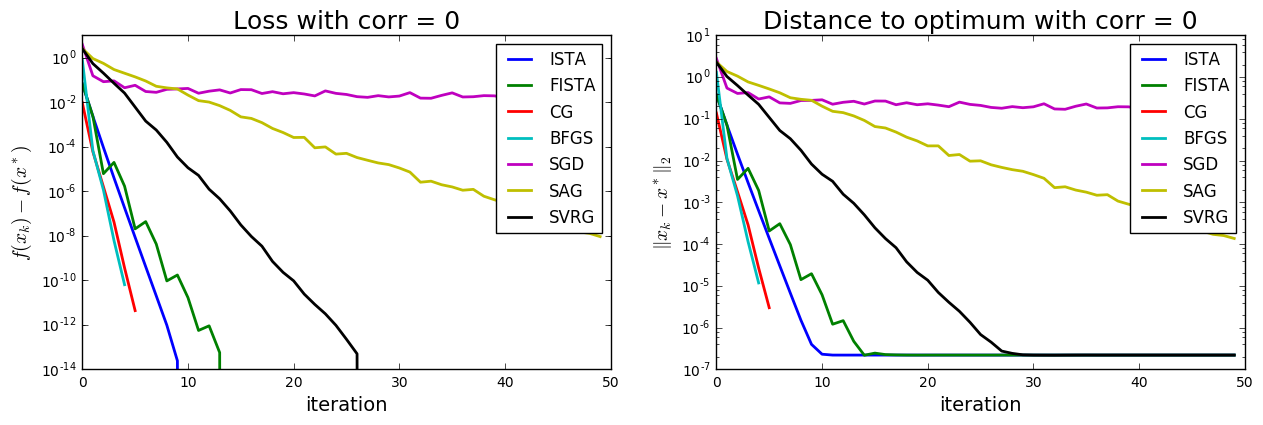

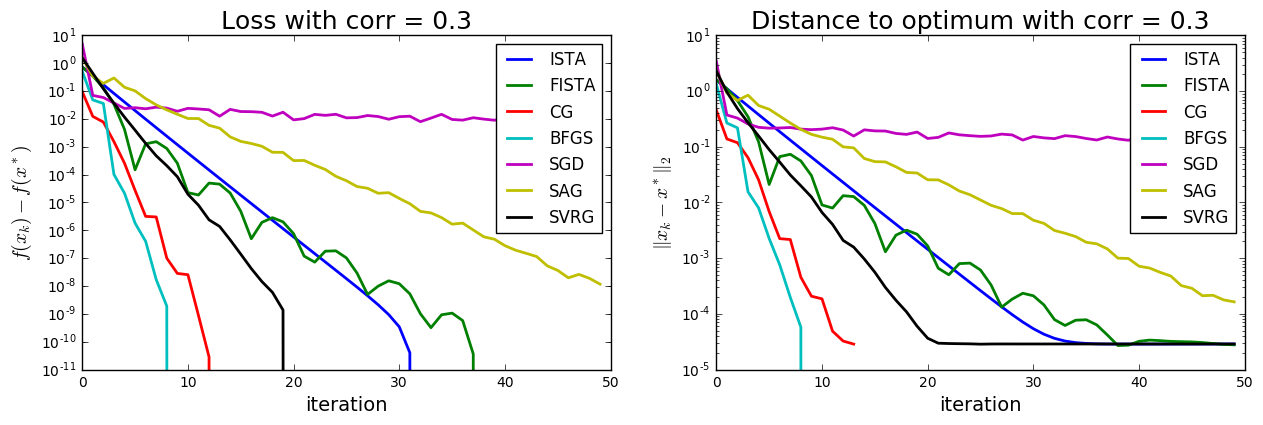

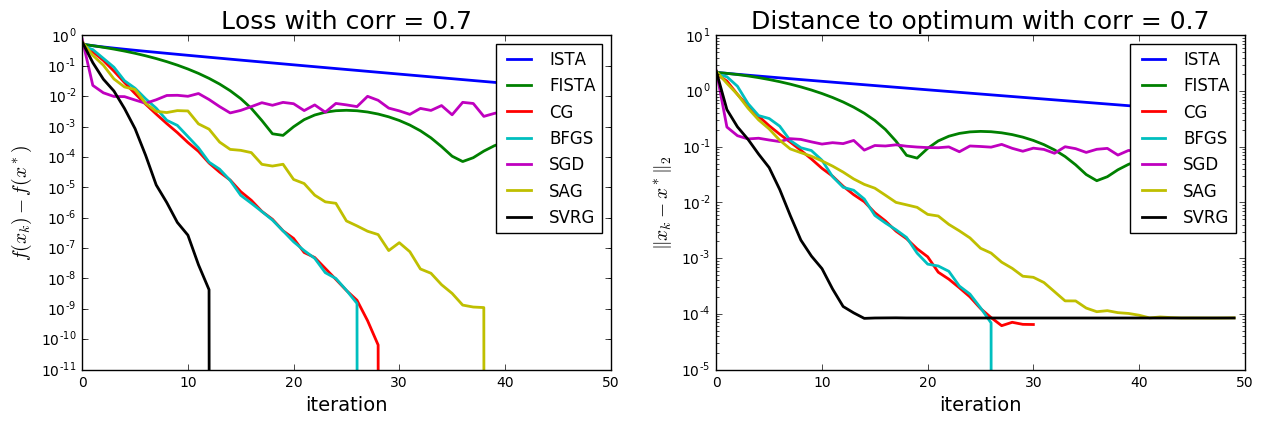

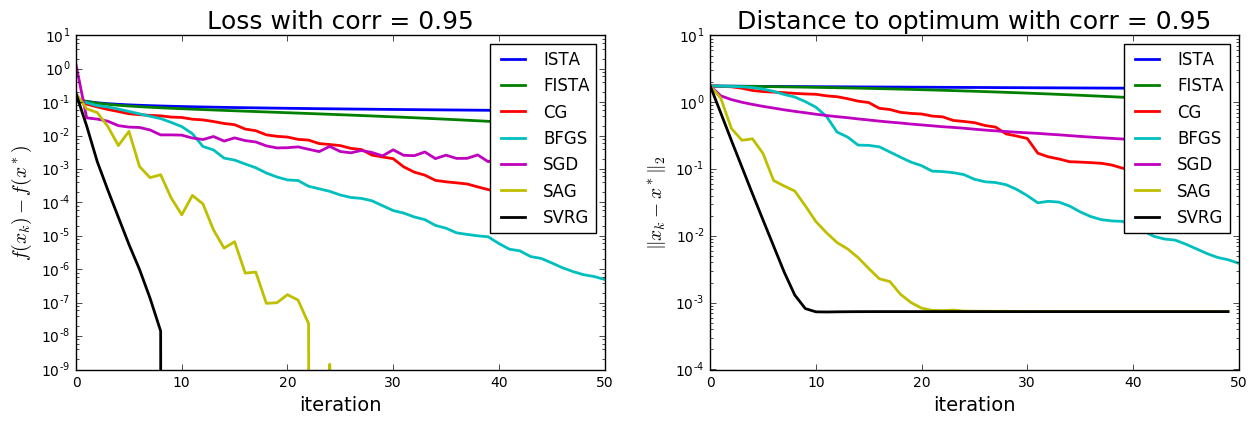

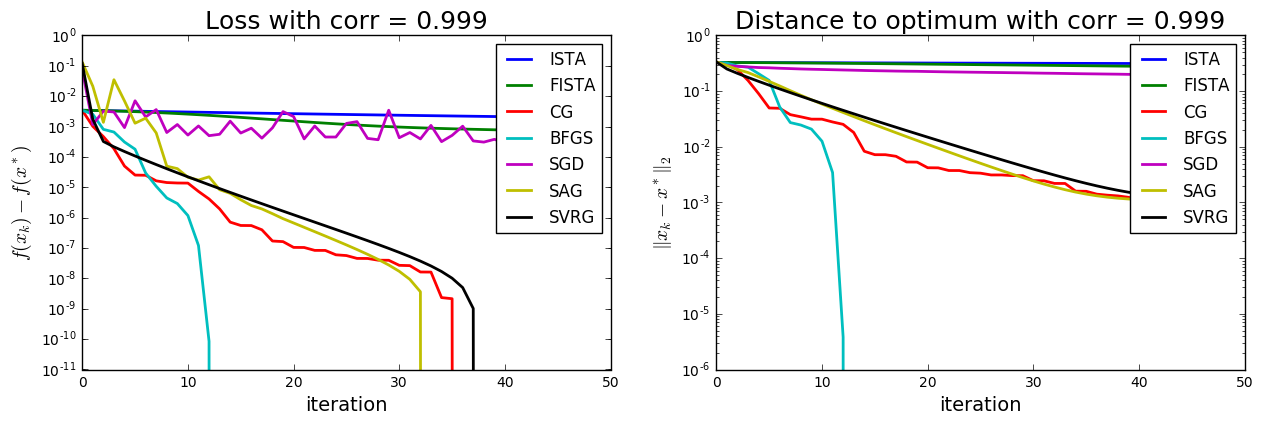

In [48]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

for corr_ind in range(len(corr_vect)):
    # Simulation
    A, b = simu_linreg(x_truth, n, std=1., corr=corr_vect[corr_ind])
    lbda = 1. / n**0.5
    model = LinReg(A, b, lbda)

    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

    n_iter = 50

    plt.figure(figsize=(15,5*len(corr_vect)))

    plt.subplot(len(corr_vect), 2, corr_ind*2+1)

    #Inspectors

    #Ista
    step = 1. / model.lipschitz_constant()
    ista_inspector = inspector(model.loss, x_truth, verbose=False)
    x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

    #Fista
    step = 1. / model.lipschitz_constant()
    fista_inspector = inspector(model.loss, x_truth, verbose=False)
    x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

    #Coordinate gradient
    cg_inspector = inspector(model.loss, x_truth, verbose=False)
    x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

    #BFGS
    bfgs_inspector = inspector(model.loss, x_truth, verbose=False)
    x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

    iis = np.random.randint(0, n, n * n_iter) 

    #SGD
    step0 = 1. / model.lipschitz_constant()
    sgd_inspector = inspector(model.loss, x_truth, verbose=False)
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

    #SAG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
    else:
        step = 1.0 / (max_squared_sum + model.lbda / model.n)
    sag_inspector = inspector(model.loss, x_truth, verbose=False)
    x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

    #SVRG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
    else:
        step = 1.0 / (max_squared_sum + model.lbda / model.n)
    svrg_inspector = inspector(model.loss, x_truth, verbose=False) 
    x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

    #Plots of each model
    inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector, 
                 sgd_inspector, sag_inspector, svrg_inspector
                 ]

    solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    for insp in inspectors:
        plt.plot(insp.obj, lw=2)
        plt.title("Loss with corr = " + str(corr_vect[corr_ind]), fontsize=18)
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
        plt.yscale("log")

    plt.legend(solvers)

    plt.subplot(len(corr_vect), 2, corr_ind*2+2)

    for insp in inspectors:
        plt.plot(insp.err, lw=2)
        plt.title("Distance to optimum with corr = " + str(corr_vect[corr_ind]), fontsize=18)
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
        plt.yscale("log")

    plt.legend(solvers);